**Ejercicio entregable 2**

El documento está orientado a la realización de una red DCNN siamesa que permita comparar entre 2 imágenes.
Para ello, se han definido todos los pasos que debereís dar y la puntuación de los mismos

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

path_img = "/content/drive/MyDrive/Deep Learning/Datasets/w16_h9_432"

Mounted at /content/drive


## Construcción del dataset

In [22]:
def image_transformation(paths,label):
  img1 = tf.io.read_file(paths[0])
  img2 = tf.io.read_file(paths[1])

  img1 = tf.image.decode_jpeg(img1, channels=3)
  img2 = tf.image.decode_jpeg(img2, channels=3)

  img1 = tf.image.resize(img1, (128,128))
  img2 = tf.image.resize(img2, (128, 128))

  return ((img1,img2),label)

In [23]:
augmentation_operations = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

def data_aumentation(images, label):
  augmented_img1 = augmentation_operations(images[0])
  augmented_img2 = augmentation_operations(images[1])
  img1 = tf.cast(augmented_img1, tf.float32)/255
  img2 = tf.cast(augmented_img2, tf.float32)/255
  return ((img1, img2), label)

In [24]:
def get_dataset(batch_size=128):
  img_paths = [os.path.join(path_img,name) for name in os.listdir(path_img)]

  #Same image
  content = [((a,a),1) for a in img_paths]

  img_paths_rotated = img_paths.copy()
  img_paths_rotated.append(img_paths_rotated.pop(0))
  content += [(e,0) for e in list(zip(img_paths, img_paths_rotated))]

  X_train, X_test, Y_train, Y_test = train_test_split([a for (a,_) in content],[b for (_,b) in content], test_size=0.2, random_state=23)

  train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(Y_train))).map(image_transformation, num_parallel_calls=tf.data.AUTOTUNE).cache().map(data_aumentation, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
  test_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_test), tf.constant(Y_test))).map(image_transformation, num_parallel_calls=tf.data.AUTOTUNE).cache().map(data_aumentation, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

  return train_data, test_data


In [25]:
train_data, test_data = get_dataset()

## Estructura del modelo

In [26]:
def get_encoder(latent):
   model = keras.models.Sequential()
   model.add(layers.Conv2D(8, 3, activation='relu', input_shape=(128,128,3)))
   model.add(layers.MaxPooling2D())
   model.add(layers.Conv2D(16, 3, activation='relu'))
   model.add(layers.MaxPooling2D())
   model.add(layers.Conv2D(32, 3, activation='relu'))
   model.add(layers.MaxPooling2D())
   model.add(layers.Conv2D(64, 3, activation='relu'))
   model.add(layers.MaxPooling2D())
   model.add(layers.Conv2D(128, 3, activation='relu'))
   model.add(layers.MaxPooling2D())
   model.add(layers.Flatten())
   model.add(layers.Dense(latent, activation='sigmoid'))
   return model

In [27]:
def get_model():
    input1 = layers.Input(shape=(128,128,3))
    input2 = layers.Input(shape=(128,128,3))
    cnn = get_encoder(32) # <<<--- Queremos crear solo 1 modelo de "rama" y usarlo en cada una
    x1 = cnn(input1)
    x2 = cnn(input2)
    d = keras.backend.abs(x1 - x2)
    r = layers.Dense(1, activation='sigmoid')(d)
    model = keras.models.Model(inputs=[input1, input2], outputs=r)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mae'])
    return model, cnn

##  Model summary

In [28]:
model, submodel = get_model()

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 32)                   114800    ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 tf.math.subtract_1 (TFOpLa  (None, 32)                   0         ['sequential_3[0][0]',  

## Callbacks

In [30]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae', patience=4, restore_best_weights=True, verbose=0)

In [31]:
reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_mae', patience=5, verbose=0)

In [32]:
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="./generated/model", monitor='val_mae', save_best_only=True, save_weights_only=False, verbose=0)

## Entrenamiento

In [33]:
history = model.fit(train_data, epochs=1000, verbose=1, validation_data=test_data, callbacks=[early_stopping,reduce_lr_on_plateau])

Epoch 1/1000
45/45 [==============================] - 129s 2s/step - loss: 0.1621 - mae: 0.3624 - val_loss: 0.1055 - val_mae: 0.2665 - lr: 0.0100
Epoch 2/1000
45/45 [==============================] - 23s 514ms/step - loss: 0.0843 - mae: 0.2301 - val_loss: 0.0860 - val_mae: 0.2419 - lr: 0.0100
Epoch 3/1000
45/45 [==============================] - 22s 500ms/step - loss: 0.0644 - mae: 0.1924 - val_loss: 0.0662 - val_mae: 0.1926 - lr: 0.0100
Epoch 4/1000
45/45 [==============================] - 24s 527ms/step - loss: 0.0477 - mae: 0.1537 - val_loss: 0.0469 - val_mae: 0.1529 - lr: 0.0100
Epoch 5/1000
45/45 [==============================] - 23s 524ms/step - loss: 0.0400 - mae: 0.1323 - val_loss: 0.0366 - val_mae: 0.1287 - lr: 0.0100
Epoch 6/1000
45/45 [==============================] - 22s 499ms/step - loss: 0.0339 - mae: 0.1181 - val_loss: 0.0263 - val_mae: 0.1030 - lr: 0.0100
Epoch 7/1000
45/45 [==============================] - 23s 505ms/step - loss: 0.0319 - mae: 0.1131 - val_loss: 0.02

## Ejemplo del dataset

In [38]:
def predict_image(model, A, B):
    image1 = tf.io.read_file(A)
    image2 = tf.io.read_file(B)
    image1 = tf.image.decode_jpeg(image1, channels=3)
    image2 = tf.image.decode_jpeg(image2, channels=3)
    image1 = tf.image.resize(image1, (128,128))
    image2 = tf.image.resize(image2, (128,128))
    image1 = tf.cast(image1, tf.float32)/255
    image2 = tf.cast(image2, tf.float32)/255
    image1 = tf.reshape(image1, (1,128,128,3))
    image2 = tf.reshape(image2, (1,128,128,3))
    prediction = model.predict([image1,image2])
    prob = prediction.max()
    return ('Identical', prob) if prob > 0.5 else ('Different', 1-prob)

In [39]:
predict_image(model, os.path.join(path_img,'1.jpg'), os.path.join(path_img,'11.jpg'))

1/1 [==============================] - 0s 32ms/step


('Different', 0.9999999999660113)

##  Gráficas de entrenamiento y test empleando las variables accuracy y loss

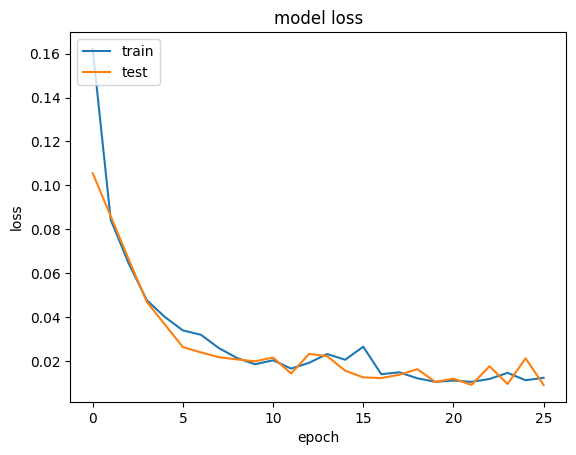

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

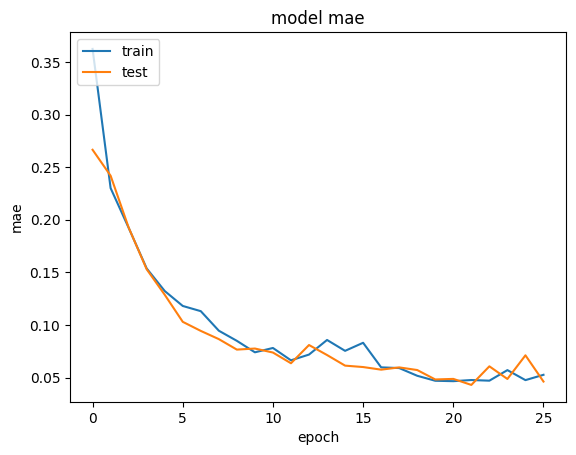

In [41]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

-